In [42]:
%run connect_twitter.ipynb

my API Connected !


In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Gathering Data</h3><br>
Find 200 most recent tweets fom user @realDonaldTrump:

In [44]:
name = '@realDonaldTrump'
nbr_tweets = 200
results = myapi.user_timeline(id=name, count=nbr_tweets)

In [45]:
type(results)

tweepy.models.ResultSet

In [46]:
data=[tweet.text for tweet in results]


Assemble the text into a dataframe

In [47]:
data = pd.DataFrame(data=[tweet.text for tweet in results],
                    columns=['Tweets'])

In [48]:
data.head()

,Tweets
0,...House Republicans are showing real LEADERSH...
1,...Pelosi and her Do Nothing Democrats drug pr...
2,...While we had the first prescription drug pr...
3,.@SecAzar and I will soon release a plan to le...
4,Thank you to @senatemajldr Mitch McConnell and...


The interesting part from here is the quantity of metadata contained in a single tweet. If we want to obtain data such as the creation date, or the source of creation, we can access the info with this attributes. An example is the following:

In [49]:
print(dir(results[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


Getting the meta data from the first tweet in the lsit

In [50]:
print('id:',results[0].id)
print('created at:',results[0].created_at)
print('source:',results[0].source)
print('likes:',results[0].favorite_count)
print('retweets:',results[0].retweet_count)
print('geo-location:',results[0].geo)
print('message:',results[0].text)

id: 1197954044393861120
created at: 2019-11-22 19:04:35
source: Twitter for iPhone
likes: 17994
retweets: 4997
geo-location: None
message: ...House Republicans are showing real LEADERSHIP and prepared to enact bipartisan solutions for drug prices. Do Not… https://t.co/YkzY7kPOKw


<h4>Adding more data to the dataframe </h4>

In [51]:
data['len']  = np.array([len(tweet.text) for tweet in results])
data['ID']   = np.array([tweet.id for tweet in results])
data['Date'] = np.array([tweet.created_at for tweet in results])
data['Source'] = np.array([tweet.source for tweet in results])
data['Likes']  = np.array([tweet.favorite_count for tweet in results])
data['RTs']    = np.array([tweet.retweet_count for tweet in results])

In [52]:
data.head()

,Tweets,len,ID,Date,Source,Likes,RTs
0,...House Republicans are showing real LEADERSH...,140,1197954044393861120,2019-11-22 19:04:35,Twitter for iPhone,17994,4997
1,...Pelosi and her Do Nothing Democrats drug pr...,139,1197954043420827648,2019-11-22 19:04:35,Twitter for iPhone,17002,4548
2,...While we had the first prescription drug pr...,139,1197954042342719488,2019-11-22 19:04:35,Twitter for iPhone,8013,2564
3,.@SecAzar and I will soon release a plan to le...,140,1197954041139146754,2019-11-22 19:04:34,Twitter for iPhone,27680,8086
4,Thank you to @senatemajldr Mitch McConnell and...,140,1197951285238083585,2019-11-22 18:53:37,Twitter for iPhone,30766,8151


<h3>Interpretation of the data</h3>

In [53]:
likes_max = np.max(data['Likes'])
retweet_max  = np.max(data['RTs'])

In [54]:
likes = data[data['Likes'] == likes_max].index[0]
retweets  = data[data.RTs == retweet_max].index[0]

In [55]:
retweets

131

In [56]:
# Max FAVs:
print("The tweet with most likes is: \n{}".format(data['Tweets'][likes]))
print("Number of likes: {}".format(likes_max))
print("{} characters.".format(data['len'][likes]))
print("Tweeted at {s}".format(s=data['Date'][likes]))

The tweet with most likes is: 
A great day for Republicans, a great day for our Country!
Number of likes: 159914
57 characters.
Tweeted at 2019-11-20 01:06:48


In [57]:
data.sort_values(by='Likes',ascending=False).head(4)

,Tweets,len,ID,Date,Source,Likes,RTs
97,"A great day for Republicans, a great day for o...",57,1196958035127783427,2019-11-20 01:06:48,Twitter for iPhone,159914,29064
131,Nancy Pelosi just stated that “it is dangerous...,140,1196658170984357888,2019-11-19 05:15:15,Twitter for iPhone,145789,43003
64,Today I opened a major Apple Manufacturing pla...,140,1197293250115014656,2019-11-20 23:18:50,Twitter for iPhone,132883,33214
151,Where is the Fake Whistleblower?,32,1196159184431177729,2019-11-17 20:12:27,Twitter for iPhone,132241,27485


<h3>Making Graphs</h3>

In [58]:
t_likes = pd.Series(data=data['Likes'].values, index=data['Date'])

In [59]:
t_retweets = pd.Series(data=data['RTs'].values, index=data['Date'])

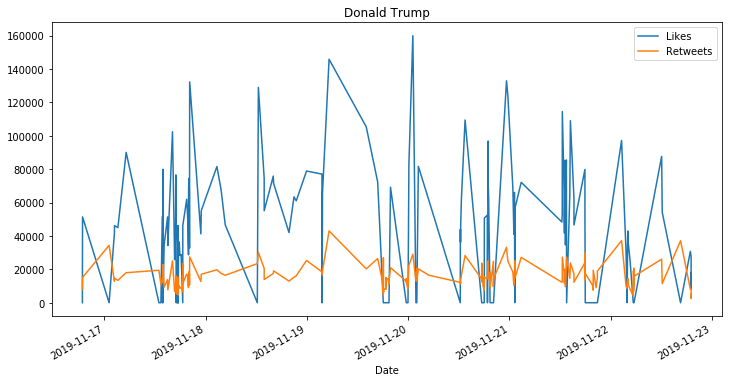

In [60]:
t_likes.plot(title='Donald Trump',
             figsize=(12,6),
             legend=True,
             label='Likes');
t_retweets.plot(legend=True,label='Retweets');

<h3>Sentiment Analysis of the Tweets</h3>

In [61]:
from textblob import TextBlob
import re

Define 2 different utility functions

In [62]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    #analysis = TextBlob(clean_tweet(tweet))
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [63]:
x  = [ analyze_sentiment(tweet) for tweet in data['Tweets'] ]

In [64]:
data['SA'] = np.array(x)

In [65]:
data.sort_values(by='Date',ascending=False,inplace=True)
data.head()

,Tweets,len,ID,Date,Source,Likes,RTs,SA
0,...House Republicans are showing real LEADERSH...,140,1197954044393861120,2019-11-22 19:04:35,Twitter for iPhone,17994,4997,1
1,...Pelosi and her Do Nothing Democrats drug pr...,139,1197954043420827648,2019-11-22 19:04:35,Twitter for iPhone,17002,4548,0
2,...While we had the first prescription drug pr...,139,1197954042342719488,2019-11-22 19:04:35,Twitter for iPhone,8013,2564,1
3,.@SecAzar and I will soon release a plan to le...,140,1197954041139146754,2019-11-22 19:04:34,Twitter for iPhone,27680,8086,1
4,Thank you to @senatemajldr Mitch McConnell and...,140,1197951285238083585,2019-11-22 18:53:37,Twitter for iPhone,30766,8151,1


The time has to be removed from the date

In [66]:
data['Date']=data['Date'].apply(lambda x : pd.to_datetime(pd.to_datetime(x).strftime('%Y%m%d')))

In [67]:
df = data.groupby('Date').sum()

In [68]:
df.head()

,len,ID,Likes,RTs,SA
Date,,,,,
2019-11-16,169.0,2.391551e+18,51403.0,23114.0,1.0
2019-11-17,4186.0,5.860865e+19,1706173.0,675842.0,2.0
2019-11-18,1346.0,1.555356e+19,846866.0,248093.0,2.0
2019-11-19,4685.0,4.428296e+19,535406.0,513236.0,8.0
2019-11-20,4104.0,4.309765e+19,1278490.0,614829.0,2.0


In [69]:
df['mood']= df['SA'].rolling(window=5).apply(lambda x : np.sum(x))

/Users/jandespiegeleer/.pyenv/versions/3.6.5/envs/seminar/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


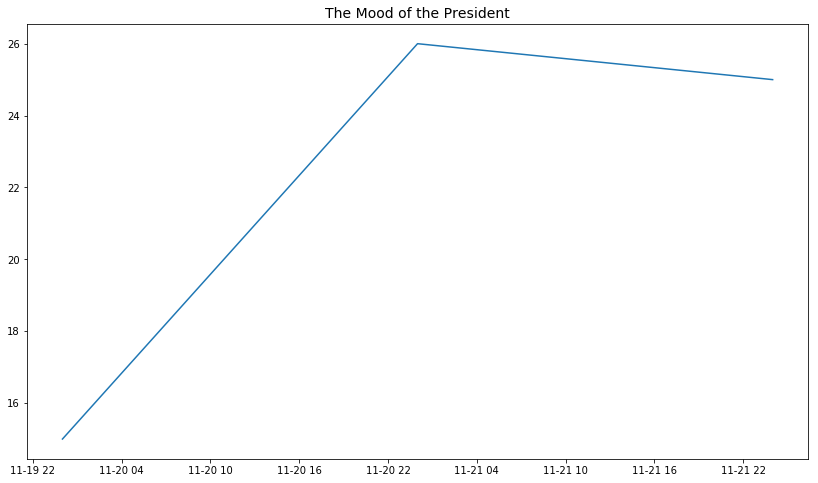

In [70]:
fig = plt.subplots(1,1,figsize=(14,8))
plt.plot(df.index,df['mood'])
plt.title('The Mood of the President',fontsize=14);

In [71]:
pos_tweets = [ tweet for index,tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]

In [72]:
print(len(pos_tweets))
print(len(neu_tweets))
print(len(neg_tweets))

63
102
35


<h4>Most Liked positive tweet</h4>

In [73]:
df_positive = data[data['SA']>0].copy()
df_positive.sort_values(by='Likes',ascending=False,inplace=True)
df_positive.head(20)

,Tweets,len,ID,Date,Source,Likes,RTs,SA
97,"A great day for Republicans, a great day for o...",57,1196958035127783427,2019-11-20,Twitter for iPhone,159914,29064,1
64,Today I opened a major Apple Manufacturing pla...,140,1197293250115014656,2019-11-20,Twitter for iPhone,132883,33214,1
144,Never has the Republican Party been so united ...,140,1196405099741896705,2019-11-18,Twitter for iPhone,128948,30197,1
53,"The Republican Party, and me, had a GREAT day ...",144,1197493067571486720,2019-11-21,Twitter for iPhone,114470,27301,1
41,I have been watching people making phone calls...,140,1197521967777222656,2019-11-21,Twitter for iPhone,109002,23842,1
182,Our great Farmers will recieve another major r...,139,1196097712925691906,2019-11-17,Twitter for iPhone,102376,25055,1
193,Visited a great family of a young man under ma...,140,1195931893998456832,2019-11-17,Twitter for iPhone,90023,17976,1
98,"I agree, but in the end we will win and save o...",106,1196943910624538625,2019-11-20,Twitter for iPhone,82789,22345,1
187,A new Republican Star is born. Great going @El...,82,1196063349844430849,2019-11-17,Twitter for iPhone,79922,20285,1
38,Iran has become so unstable that the regime ha...,140,1197573996960727041,2019-11-21,Twitter for iPhone,79779,24005,1


<b> What about the stock market </b>

In [74]:
from googlefinance.client import get_price_data

In [75]:
param_SPX = {'q': ".INX","p" : "1Y",'i': "86400"}

In [76]:
df_SPX = get_price_data(param_SPX)
df_SPX.head()

,Open,High,Low,Close,Volume


In [77]:
df_SPX.index = pd.to_datetime(df_SPX.index).strftime('%Y%m%d')
df.index = pd.to_datetime(df.index).strftime('%Y%m%d')
df_combination = pd.concat([df_SPX['Close'],df['mood']],axis=1)
df_combination.dropna(how='any',inplace=True)

/Users/jandespiegeleer/.pyenv/versions/3.6.5/envs/seminar/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
df_combination['mood']= 100*df_combination['mood']/df_combination['mood'].values[0]
df_combination['Close']= 100*df_combination['Close']/df_combination['Close'].values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(15,10),sharex=True)
ax[0].plot(df_combination.index,df_combination['mood'])
ax[0].set_title('Mood of the President')
ax[1].plot(df_combination.index,df_combination['Close'])
ax[1].set_title('S&P 500');